**Text Classification of Coronavirus Tweets**

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.

https://www.kaggle.com/competitions/sentence-classification-of-coronavirus-tweets/overview

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from collections import defaultdict

Сразу уберем твиты с нейтральной окраской

Попробуем сначала разделить выборку на 2 класса - положительный, отрицательный

In [55]:
traiiin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [2]:
test = pd.read_csv('/content/Corona_NLP_test.csv', encoding='latin-1')
train = pd.read_csv('/content/Corona_NLP_train.csv', encoding='latin-1')
train = train[train['Sentiment']!='Neutral']
print(train.shape)
print(test.shape)
train.head(10)

(33444, 6)
(3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative
11,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",Extremely Positive
12,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÂs ALL ...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33444 entries, 1 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       26395 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


## Подготовка

Преобразуем target:
1 - если окраска положительная,
0 - если отрицательная

Очевидно, столбцы UserName и ScreenName никак не влияют на таргет, можно их удалить

In [4]:
train.Sentiment = train.Sentiment.map(lambda x: 1 if 'Positive' in x else 0)
train.drop(['UserName','ScreenName'],axis=1,inplace = True)
train.fillna('Unknown',inplace = True)
train.head(10)

,Location,TweetAt,OriginalTweet,Sentiment
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
4,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
5,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,1
6,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,1
8,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,1
9,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",0
11,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",1
12,Horningsea,16-03-2020,#horningsea is a caring community. LetÂs ALL ...,1


In [5]:
train["TweetAt"] = pd.to_datetime(train["TweetAt"],format="%d-%m-%Y")
train.head(10)

,Location,TweetAt,OriginalTweet,Sentiment
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,1
3,Unknown,2020-03-16,My food stock is not the only one which is emp...,1
4,Unknown,2020-03-16,"Me, ready to go at supermarket during the #COV...",0
5,"ÃT: 36.319708,-82.363649",2020-03-16,As news of the regionÂs first confirmed COVID...,1
6,"35.926541,-78.753267",2020-03-16,Cashier at grocery store was sharing his insig...,1
8,"Atlanta, GA USA",2020-03-16,Due to COVID-19 our retail store and classroom...,1
9,"BHAVNAGAR,GUJRAT",2020-03-16,"For corona prevention,we should stop to buy th...",0
11,"Pitt Meadows, BC, Canada",2020-03-16,"Due to the Covid-19 situation, we have increas...",1
12,Horningsea,2020-03-16,#horningsea is a caring community. LetÂs ALL ...,1


In [6]:
train['Sentiment'].value_counts()

,count
Sentiment,
1,18046
0,15398


## Токенизация

### Ручной токенайзер

Построим словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр

Получился словарь на 100,000 эл-тов где наиболее популярные токены это предлоги,
которые не несут смысловой нагрузки

In [7]:
tokens = defaultdict(int)
for text in train["OriginalTweet"]:
  for word in text.lower().split():
    tokens[word] += 1
print(len(tokens))
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
print(sorted_tokens[:10])

103198
[('the', 38250), ('to', 33447), ('and', 20935), ('of', 18578), ('a', 16667), ('in', 16024), ('for', 12193), ('#coronavirus', 11759), ('is', 10596), ('are', 9958)]


In [8]:
#удалим все бесполезные токены
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
tokens = {k: v for k, v in tokens.items() if k not in stopwords.words('english')}
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
print(sorted_tokens[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 11759), ('prices', 5625), ('food', 5409), ('grocery', 4882), ('supermarket', 4662), ('covid-19', 4504), ('people', 4488), ('store', 4486), ('#covid19', 3561), ('consumer', 3233)]


### TweetTokenizer

In [9]:
from nltk.tokenize import TweetTokenizer
from string import punctuation

tknzr = TweetTokenizer()
TT_tokens = defaultdict(int)
for text in train.OriginalTweet:
  for word in tknzr.tokenize(text.lower()):
    TT_tokens[word] += 1

TT_tokens = {k: v for k, v in TT_tokens.items() if k not in stopwords.words('english') and k not in punctuation}
sorted_TT_tokens = sorted(TT_tokens.items(), key=lambda x: x[1], reverse=True)
print(sorted_TT_tokens[:10]),len(sorted_TT_tokens)


[('#coronavirus', 12587), ('19', 10142), ('covid', 8832), ('prices', 6644), ('food', 6213), ('\x92', 6190), ('store', 5494), ('supermarket', 5435), ('grocery', 4959), ('people', 4902)]


(None, 74801)

Удалим из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

In [10]:
TT_tokens = {k: v for k, v in TT_tokens.items() if not (len(k) ==1 and ord(k) >= 128)}
sorted_TT_tokens = sorted(TT_tokens.items(), key=lambda x: x[1], reverse=True)

In [11]:
sorted_TT_tokens[:20]

[('#coronavirus', 12587),
 ('19', 10142),
 ('covid', 8832),
 ('prices', 6644),
 ('food', 6213),
 ('store', 5494),
 ('supermarket', 5435),
 ('grocery', 4959),
 ('people', 4902),
 ('#covid19', 3726),
 ('consumer', 3367),
 ('online', 2686),
 ('shopping', 2683),
 ('#covid_19', 2525),
 ('get', 2478),
 ('...', 2458),
 ('panic', 2372),
 ('need', 2369),
 ('workers', 2369),
 ('like', 2301)]

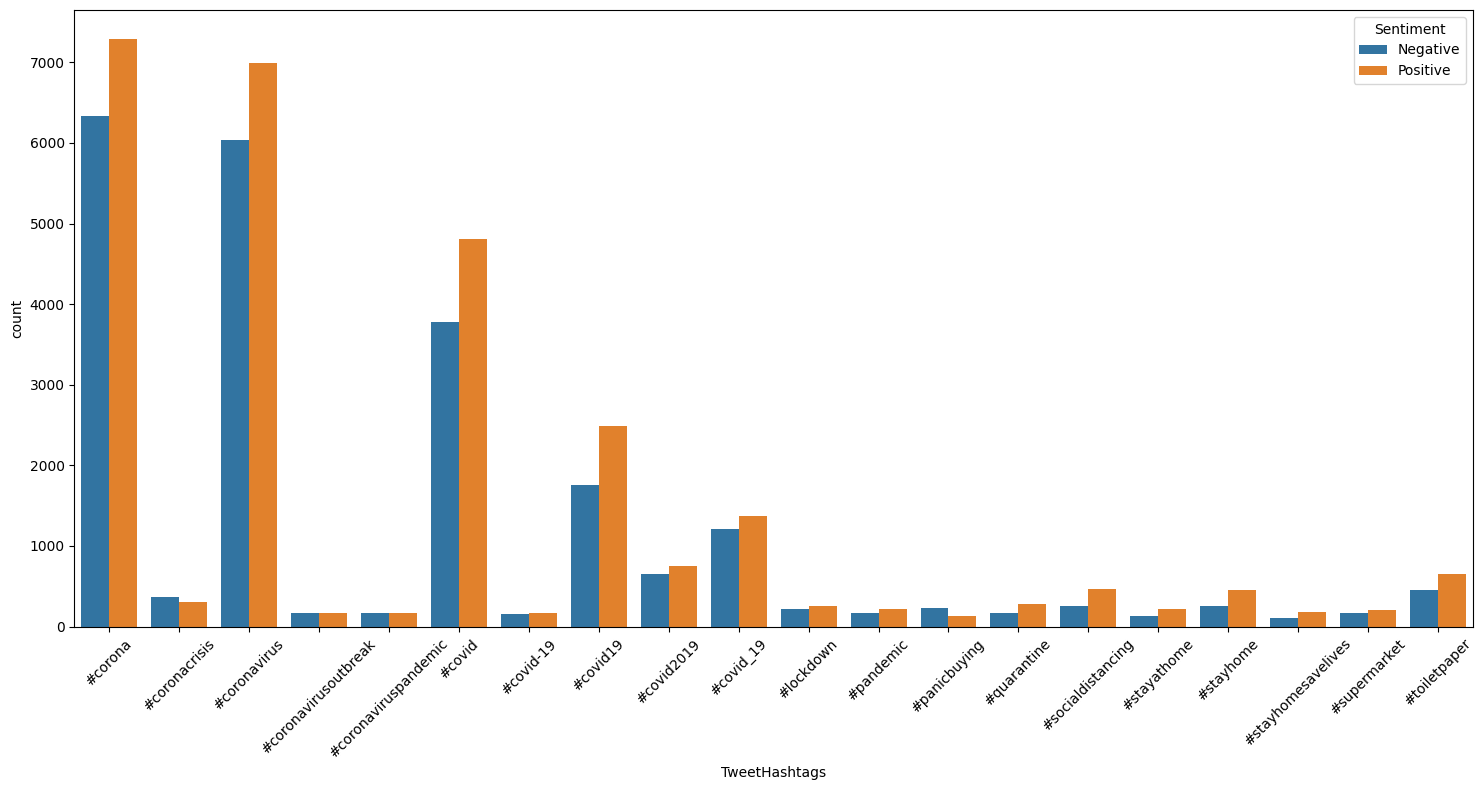

In [12]:
top_20_hashtags = [k for k, v in sorted_TT_tokens if k.startswith('#')][:20]

def get_tweet_hashtags(tweet, hashtags):
    return [hashtag for hashtag in hashtags if hashtag in tweet.lower()]

train_filtered = train.copy()
train_filtered['TweetHashtags'] = train_filtered['OriginalTweet'].apply(lambda x: get_tweet_hashtags(x, top_20_hashtags))
train_filtered = train_filtered[train_filtered['TweetHashtags'].apply(lambda x: len(x) > 0)]


train_filtered_exploded = train_filtered.explode('TweetHashtags')

hashtag_sentiment_individual = train_filtered_exploded.groupby(['TweetHashtags', 'Sentiment']).size().reset_index(name='count')
hashtag_sentiment_individual['Sentiment'] = hashtag_sentiment_individual['Sentiment'].map({0: 'Negative', 1: 'Positive'})


plt.figure(figsize=(15, 8))
sns.barplot(data=hashtag_sentiment_individual, x='TweetHashtags', y='count', hue='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Тоже бесполезная информация
sorted([(k,v) for k, v in tokens.items() if k.startswith('https://t.co')],key = lambda x:x[1],reverse = True)[:20]


[('https://t.co/oxa7swtond', 6),
 ('https://t.co/g63rp042ho', 5),
 ('https://t.co/r7sagojsjg', 4),
 ('https://t.co/wrlhyzizaa', 4),
 ('https://t.co/ymsemlvttd', 4),
 ('https://t.co/3kfuiojxep.', 4),
 ('https://t.co/oi39zsanq8', 4),
 ('https://t.co/6yvykiab2c', 4),
 ('https://t.co/xpcm2xkj4o', 4),
 ('https://t.co/gu6b4xpqp4', 4),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/jpgmr5hcsc', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/wuieefsnoj', 3),
 ('https://t.co/btxzpmqlpb', 3),
 ('https://t.co/hpo7uwkakl', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/spqy4xixyn', 3)]

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [14]:
def custom_tokenizer(text):
  tokens = []
  tokenizer = TweetTokenizer()

  for token in tokenizer.tokenize(text.lower()):
    if (token not in stopwords.words('english') and token not in punctuation
    and not (len(token) ==1 and ord(token) >= 128) and not token.startswith('https://t.co')):
      tokens.append(token)
  return tokens


## Векторизация

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)
cv.fit(train.OriginalTweet)

print(len(cv.vocabulary_))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


56538


Посмотрим на примере как работает векторайзер

In [16]:
train.loc[2536]['OriginalTweet'], train.loc[2536]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

In [17]:
X = cv.transform([train.loc[2536]['OriginalTweet']])
vector_array = X.toarray().flatten()
feature_names = cv.get_feature_names_out()

nonzero_tokens = {
    feature_names[i]: vector_array[i]
    for i in np.nonzero(vector_array)[0]
}

nonzero_tokens

{'#coronavirusoutbreak': np.int64(1),
 '#covid2019': np.int64(1),
 '@skynews': np.int64(1),
 'brainless': np.int64(1),
 'ffs': np.int64(1),
 'food': np.int64(1),
 'france': np.int64(1),
 'lets': np.int64(1),
 'nice': np.int64(1),
 'one': np.int64(1),
 'panic': np.int64(1),
 'ppl': np.int64(1),
 'queueing': np.int64(1),
 'show': np.int64(1)}

In [18]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)]

,Location,TweetAt,OriginalTweet,Sentiment
55,"West Midlands, England",2020-03-16,Morning everyone have a great and safe day. ??...,1
58,Unknown,2020-03-16,"With the outbreak of Covid-19 in entire world,...",1
90,"Houston, TX",2020-03-16,Just called mum and dad in UK (over 70). They ...,1
235,"California, USA",2020-03-16,With the Coronavirus going out and shopping fo...,1
236,"San Diego, CA",2020-03-16,"What's a good way to support grocery store, me...",1
...,...,...,...,...
40628,"Illinois, USA",2020-04-13,How have you been keeping your kids busy? @ori...,1
40864,Bangalore,2020-04-13,Their share prices might be lower because of t...,1
41027,"Toronto, ONT, Canada",2020-04-14,this deck by .@lukew in insanely good - great ...,1
41072,"Rawalpindi, Pakistan",2020-04-14,"At Mr Tasty , we aim to provide great Taste an...",1


In [19]:
train.loc[24179].OriginalTweet,train.loc[24179].Sentiment

('Thank you to the medical professionals, scientists, the honest, dedicated government leaders, the grocery store and other essential business/service workers. . . you are doing a great job! I appreciate this. #coronavirus',
 np.int64(1))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer = custom_tokenizer).fit(train.OriginalTweet)

positive_tweet = tfidf.transform([train.loc[24179]['OriginalTweet']])

vector_array = positive_tweet.toarray().flatten()
feature_names = tfidf.get_feature_names_out()

nonzero_tokens = {
    feature_names[i]: vector_array[i]
    for i in np.nonzero(vector_array)[0]
}
sorted([(k,v) for k,v in nonzero_tokens.items()],key = lambda x: x[1],reverse=True)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[('. . .', np.float64(0.35115592287860586)),
 ('honest', np.float64(0.3252169507078306)),
 ('scientists', np.float64(0.2961664819462061)),
 ('dedicated', np.float64(0.2873151589670618)),
 ('professionals', np.float64(0.27809936331461577)),
 ('leaders', np.float64(0.2748499980328721)),
 ('appreciate', np.float64(0.26434020810737474)),
 ('job', np.float64(0.2186534612852919)),
 ('medical', np.float64(0.21100923412132797)),
 ('service', np.float64(0.20892561308486127)),
 ('great', np.float64(0.1989568501027708)),
 ('government', np.float64(0.19304007094404657)),
 ('business', np.float64(0.1927577459310904)),
 ('essential', np.float64(0.19083580961730268)),
 ('thank', np.float64(0.1870064882366981)),
 ('workers', np.float64(0.1540844582947505)),
 ('grocery', np.float64(0.11707753682474246)),
 ('store', np.float64(0.1135184043119847)),
 ('#coronavirus', np.float64(0.07866398632083656))]

## Обучение первых моделей

In [21]:
def process_dataset(dataset):
  dataset.Sentiment = dataset.Sentiment.map(lambda x: 1 if 'Positive' in x else 0)
  dataset.drop(['UserName','ScreenName'],axis=1,inplace = True)
  dataset.fillna('Unknown',inplace = True)
  dataset["TweetAt"] = pd.to_datetime(dataset["TweetAt"],format="%d-%m-%Y")

process_dataset(test)

In [22]:
X_train_cv = cv.transform(train.OriginalTweet)
X_train_tfidf = tfidf.transform(train.OriginalTweet)
y_train = train.Sentiment

X_test_cv = cv.transform(test.OriginalTweet)
X_test_tfidf = tfidf.transform(test.OriginalTweet)
y_test = test.Sentiment

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg_cv = LogisticRegression().fit(X_train_cv, y_train)
logreg_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)

y_test_pred_cv = logreg_cv.predict(X_test_cv)
y_test_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)


print('train data: ')
print("accuracy cv_vectorizer - ", accuracy_score(logreg_cv.predict(X_train_cv), y_train))
print('accuracy tf-idf vectorizer - ', accuracy_score(logreg_tfidf.predict(X_train_tfidf), y_train))

print('test data: ')
print('accuracy cv vectorizer - ',accuracy_score(test.Sentiment, y_test_pred_cv))
print('accuracy tf-idf vectorizer - ',accuracy_score(test.Sentiment, y_test_pred_tfidf))

train data: 
accuracy cv_vectorizer -  0.979936610453295
accuracy tf-idf vectorizer -  0.9257265877287406
test data: 
accuracy cv vectorizer -  0.8162190626645603
accuracy tf-idf vectorizer -  0.7833070036861506


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test.Sentiment, y_test_pred_cv))
print(confusion_matrix(test.Sentiment, y_test_pred_cv))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2252
           1       0.72      0.89      0.80      1546

    accuracy                           0.82      3798
   macro avg       0.82      0.83      0.81      3798
weighted avg       0.83      0.82      0.82      3798

[[1724  528]
 [ 170 1376]]


## Стемминг

Для уменьшения словаря можно использовать стемминг.


In [25]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):

  tokens = custom_tokenizer(text)
  stemmer = SnowballStemmer('english')
  tokens = [stemmer.stem(token) for token in tokens]
  return tokens

In [27]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)

X_train_cv = cv.transform(train.OriginalTweet)
X_train_tfidf = tfidf.transform(train.OriginalTweet)

X_test_cv = cv.transform(test.OriginalTweet)
X_test_tfidf = tfidf.transform(test.OriginalTweet)

print(len(cv.vocabulary_))
print(len(tfidf.vocabulary_))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


46301
46301


In [28]:
logreg_cv = LogisticRegression().fit(X_train_cv,train.Sentiment)
logreg_tfidf = LogisticRegression().fit(X_train_tfidf, train.Sentiment)

y_pred_cv = logreg_cv.predict(X_test_cv)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print('test data : ')
print('accuracy cv vectorizer - ',accuracy_score(test.Sentiment, y_pred_cv))
print('accuracy tf-idf vectorizer - ',accuracy_score(test.Sentiment, y_pred_tfidf))
# как видим применение стемминга особо не повлияло

test data : 
accuracy cv vectorizer -  0.7983149025803055
accuracy tf-idf vectorizer -  0.7848867825171143


## Эксперименты с векторизацией

In [29]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train.OriginalTweet
                            )
X_train_cv = cv_df.transform(train.OriginalTweet)
X_test_cv = cv_df.transform(test.OriginalTweet)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


4580


In [30]:
logreg_cv = LogisticRegression().fit(X_train_cv,train.Sentiment)
y_pred_cv = logreg_cv.predict(X_test_cv)
accuracy_score(test.Sentiment, y_pred_cv)

0.8014744602422328

In [31]:
from math import log
from sklearn.preprocessing import StandardScaler
skaler = StandardScaler(with_mean=False).fit(X_train_cv)
X_cv_stem_scaled = skaler.transform(X_train_cv)
logreg_cv = LogisticRegression().fit(X_cv_stem_scaled,train.Sentiment)
y_pred_cv = logreg_cv.predict(skaler.transform(cv_df.transform(test.OriginalTweet)))
accuracy_cv_stem = accuracy_score(test.Sentiment, y_pred_cv)
accuracy_cv_stem

0.7904160084254871

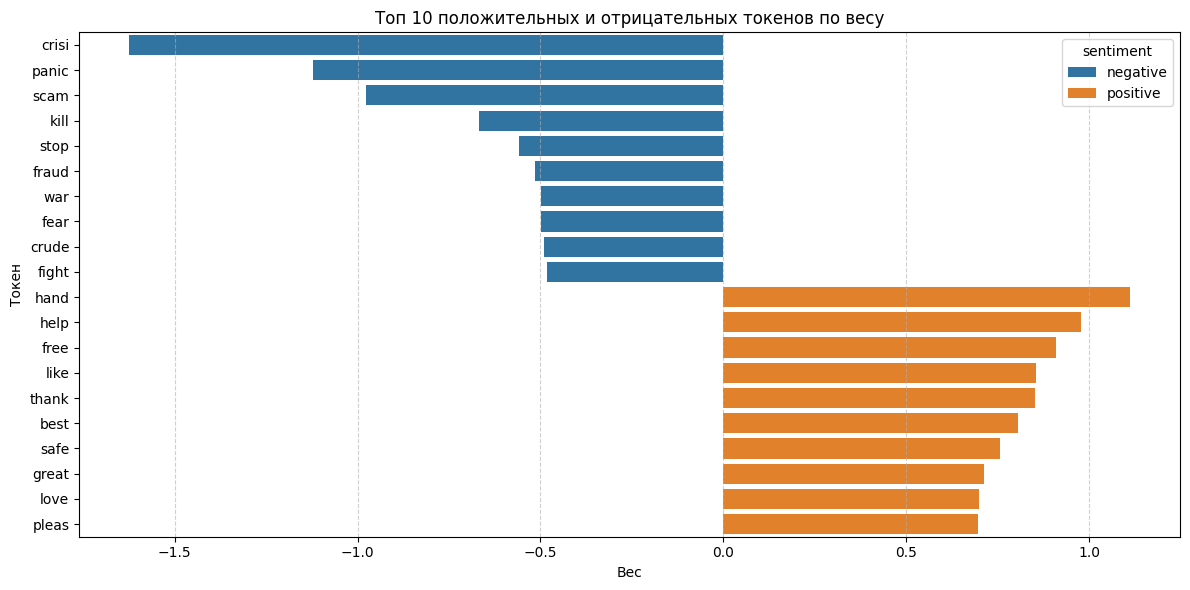

In [32]:
feature_names = cv_df.get_feature_names_out()
coefs = logreg_cv.coef_[0]

# Создаем DataFrame с токенами и их весами
coef_df = pd.DataFrame({
    'token': feature_names,
    'weight': coefs
})

# Наибольшие  веса
top_positive = coef_df.sort_values(by='weight', ascending=False).head(10)

# Наименьшие веса
top_negative = coef_df.sort_values(by='weight').head(10)


top_tokens = pd.concat([top_negative, top_positive])
top_tokens['sentiment'] = ['negative']*10 + ['positive']*10

plt.figure(figsize=(12, 6))
sns.barplot(data=top_tokens, x='weight', y='token', hue='sentiment', dodge=False)
plt.title('Топ 10 положительных и отрицательных токенов по весу')
plt.xlabel('Вес')
plt.ylabel('Токен')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Остальные признаки

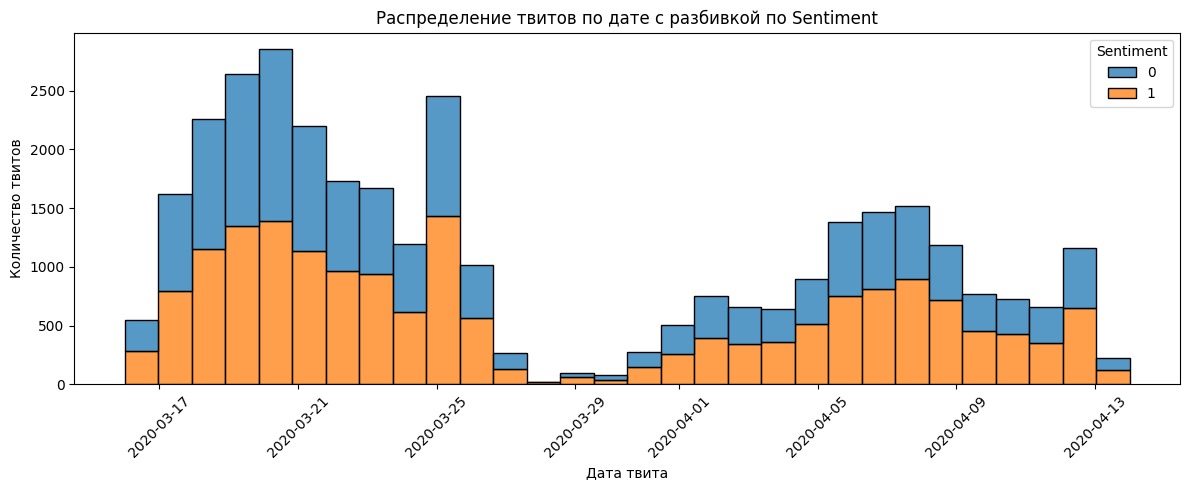

In [33]:
plt.figure(figsize=(12, 5))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', multiple='stack', bins=30)
plt.title('Распределение твитов по дате с разбивкой по Sentiment')
plt.xlabel('Дата твита')
plt.ylabel('Количество твитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#дата твита не влияет на таргет

/tmp/ipython-input-109026418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


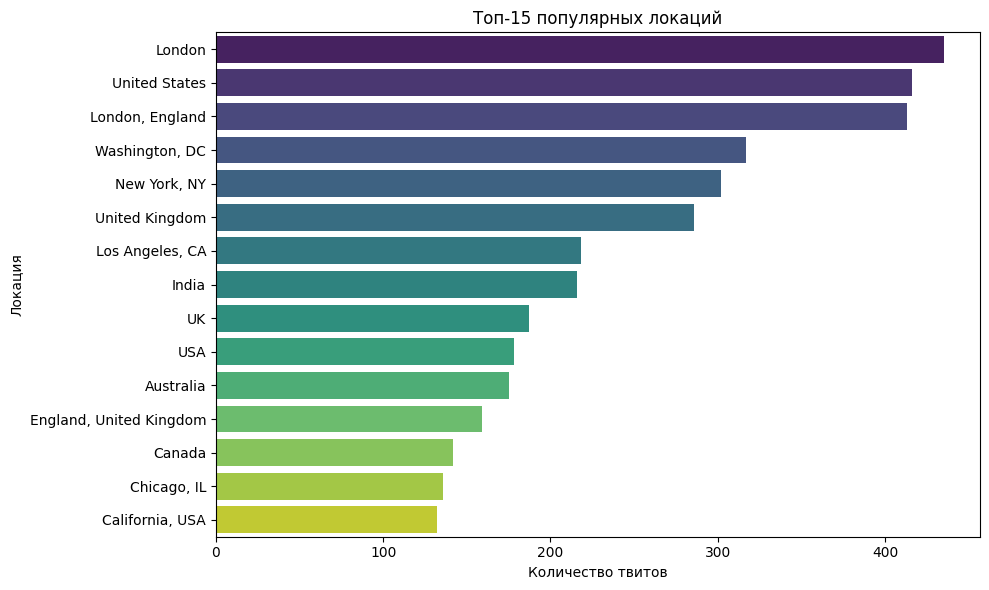

In [35]:
top_locations = train[train.Location !='Unknown'].Location.value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Топ-15 популярных локаций')
plt.xlabel('Количество твитов')
plt.ylabel('Локация')
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак, который который содержит более общее местоположение.

In [36]:
train['Location'] = train['Location'].str.split(",").str[0]
test['Location'] = test['Location'].str.split(",").str[0]
train.Location.value_counts()

,count
Location,
Unknown,7052
London,999
New York,543
Washington,427
United States,418
...,...
North Essex,1
ny,1
Wall Street,1


In [37]:
def get_wider_location(location: str) -> str:
    location_to_country = {
      # USA
      'New York': 'United States', 'New York City': 'United States',
      'United States': 'United States', 'Washington': 'United States',
      'Los Angeles': 'United States', 'Chicago': 'United States',
      'California': 'United States', 'USA': 'United States',
      'Boston': 'United States', 'Texas': 'United States',
      'Atlanta': 'United States', 'Houston': 'United States',
      'Austin': 'United States', 'Philadelphia': 'United States',
      'Dallas': 'United States', 'Seattle': 'United States',
      'Florida': 'United States', 'New Jersey': 'United States',
      'San Diego': 'United States', 'Denver': 'United States',
      'Las Vegas': 'United States', 'Michigan': 'United States',
      'Miami': 'United States', 'Brooklyn': 'United States',

      # UK
      'London': 'United Kingdom', 'UK': 'United Kingdom',
      'United Kingdom': 'United Kingdom', 'England': 'United Kingdom',
      'Manchester': 'United Kingdom', 'Scotland': 'United Kingdom',

      # Canada
      'Toronto': 'Canada', 'Vancouver': 'Canada',
      'Ottawa': 'Canada', 'Canada': 'Canada',

      # India
      'India': 'India', 'New Delhi': 'India', 'Mumbai': 'India',

      # Australia
      'Australia': 'Australia', 'Sydney': 'Australia', 'Melbourne': 'Australia',

      # Africa
      'Lagos': 'Nigeria', 'Nigeria': 'Nigeria', 'Nairobi': 'Kenya',
      'South Africa': 'South Africa',

      # Asia
      'Singapore': 'Singapore', 'Dubai': 'United Arab Emirates',

      # Global/Unknown
      'Global': 'Global', 'Worldwide': 'Global', 'Unknown': 'Unknown'
    }
    if location not in location_to_country:
        return location

    return location_to_country[location]

train['WiderLocation'] = train.Location.apply(get_wider_location)
test['WiderLocation'] = test.Location.apply(get_wider_location)
train.WiderLocation.value_counts().shape

(8333,)

/tmp/ipython-input-1009422867.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


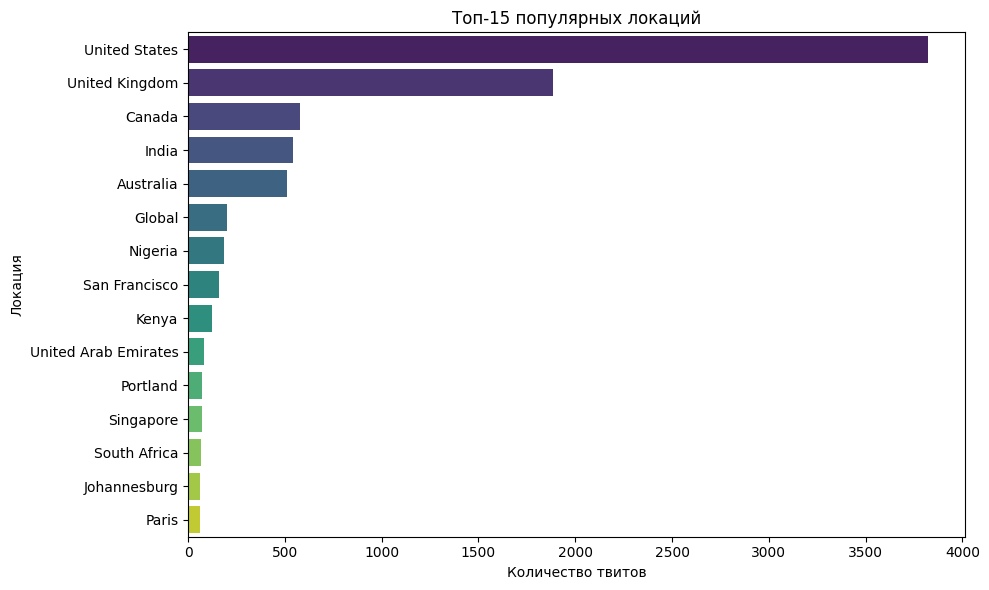

In [38]:
top_locations = train[train.Location !='Unknown'].WiderLocation.value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Топ-15 популярных локаций')
plt.xlabel('Количество твитов')
plt.ylabel('Локация')
plt.tight_layout()
plt.show()

Закодируем признак WiderLocation.


In [39]:
from sklearn.preprocessing import OneHotEncoder
import scipy

value_counts = train.WiderLocation.value_counts()[train.WiderLocation.value_counts()>1]


valid_locations = value_counts.index.tolist()

encoder = OneHotEncoder(
    categories=[valid_locations],
    handle_unknown='ignore'
)

encoder.fit(train[['WiderLocation']])


X_train_cv_withloc = scipy.sparse.hstack([X_train_cv, encoder.transform(train[['WiderLocation']])])

In [40]:
X_test_cv_withloc = scipy.sparse.hstack([
    X_test_cv,
    encoder.transform(test[['WiderLocation']])])

logreg_withloc = LogisticRegression().fit(X_train_cv_withloc,train.Sentiment)
y_pred_withloc = logreg_withloc.predict(X_test_cv_withloc)
accuracy_score(y_pred_withloc,test.Sentiment)

0.8043707214323328

качество не изменилось

In [41]:
from xgboost import XGBClassifier
# param = {'n_estimators'}
accuracy_mass = {}
for i in range(100,2000,100):
  xgmodel = XGBClassifier(n_estimators = i).fit(X_train_cv_withloc,train.Sentiment)
  y_pred_xg = xgmodel.predict(X_test_cv_withloc)
  accuracy_mass[i] = accuracy_score(y_pred_xg,test.Sentiment)
accuracy_mass

{100: 0.710637177461822,
 200: 0.7427593470247499,
 300: 0.7759347024749869,
 400: 0.7875197472353871,
 500: 0.8077935755660874,
 600: 0.8075302790942601,
 700: 0.8170089520800421,
 800: 0.8167456556082149,
 900: 0.817798841495524,
 1000: 0.8170089520800421,
 1100: 0.8183254344391785,
 1200: 0.8172722485518694,
 1300: 0.817798841495524,
 1400: 0.8167456556082149,
 1500: 0.817798841495524,
 1600: 0.8167456556082149,
 1700: 0.8167456556082149,
 1800: 0.8175355450236966,
 1900: 0.817798841495524}

In [42]:
xgmodel = XGBClassifier(n_estimators = 2000,max_depth = 4,learning_rate = 0.18,n_jobs = -1).fit(X_train_cv_withloc,train.Sentiment)
y_pred_xg = xgmodel.predict(X_test_cv_withloc)
accuracy_score(y_pred_xg,test.Sentiment)

0.8106898367561874

In [43]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.5 MB/s eta 0:00:00


In [44]:

from gensim.models import Word2Vec

temp = train.OriginalTweet.apply(custom_stem_tokenizer)

model_w2v = Word2Vec(sentences=temp,vector_size=100, window=5, min_count=2, workers=4)

def tweet_vector(tokens):
    vectors = [model_w2v.wv[word] for word in tokens if word in model_w2v.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

temp = temp.apply(tweet_vector)

X_train = np.vstack(temp.values)
y_train = train.Sentiment.astype(int)
X_test = np.vstack(test.OriginalTweet.apply(custom_stem_tokenizer).apply(tweet_vector).values)

clf = LogisticRegression().fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_pred,test.Sentiment)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6371774618220116

In [60]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(train.OriginalTweet, show_progress_bar=True)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

Batches:   0%|          | 0/1046 [00:00<?, ?it/s]

In [62]:
import plotly.express as px
import pandas as pd

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Sentiment'] = train['Sentiment']

fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='Sentiment',
    color_discrete_map={0: 'royalblue', 1: 'orange'},
    title='PCA твитов COVID (Sentiment)'
)
fig.show()